# Learning to play Cart-Pole with Policy Gradeint
This notebook shows how to implement a Policy Gradient algoirthm on the Cart-Pole game. In this game, the player controls a cart, with a pole standing on it. Due to gravity, the pole falls down, and the player's goal is to balance it. If the pole falls below a certain angle, or the cart exits the frame, the player loses.

## The Enviornment
We'll be using Open AI's [Gym](https://gym.openai.com/) library for the Cart-Pole enviornment, and Tensorflow to design the model.
In this implementation of Cart-Pole, two actions exist: 
* 0: move the cart to the left
* 1: move the cart to the right

Each state is made of 4 numbers:
* Cart Position       
* Cart Velocity    
* Pole Angle    
* Pole Velocity At Tip   

More information on the allowed values can be found on the environment [GitHub page](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py)

In [1]:
import gym
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.utils import shuffle
from scipy.stats import zscore

Define some hyper-parameters:

In [2]:
hidden_layers = [12,24,24,12]
gamma = 0.99
learning_rate = 0.001
max_steps = 500  # the number of maximum steps which can be played in a given episode

Setting up the environment:

In [3]:
env = gym.make('CartPole-v1')
env._max_episode_steps = max_steps

Time to design the network. We'll design a network with two output nodes, one for each action. Our policy $\pi$ for action selection will be a softmax over the outputs - so, the probabilty of selecting the action `left` will be:

$$ p(a_{left}) = \frac{e^{z_{left}}}{e^{z_{left}}+e^{z_{right}}} $$

Where $z_i$ is the network's output corresponding to action $i$. Note that the required gradeints and logarithm for training are performed for us by Tensorflow (the logarithm is performed as part of `softmax_cross_entropy_with_logits_v2` ([see here](https://stackoverflow.com/questions/49377483/about-tf-nn-softmax-cross-entropy-with-logits-v2)), and the gradients are calculated by the `optimizer`. 

In [4]:
sess = tf.Session()
nn_states = tf.placeholder(shape=(None, 4), dtype=tf.float32, name='input_states')
nn_acc_r = tf.placeholder(shape=None, dtype=tf.float32, name='accumalated_rewards')
nn_actions = tf.placeholder(shape=None, dtype=tf.float32, name='actions')
layer = nn_states
for i in range(len(hidden_layers)):
    layer = tf.layers.dense(inputs=layer, units=hidden_layers[i], activation=tf.nn.relu,
                            kernel_initializer=tf.contrib.layers.xavier_initializer(),
                            name='hidden_layer_{}'.format(i+1))
last_layer = tf.layers.dense(inputs=layer, units=env.action_space.n, activation=tf.nn.tanh,
                             kernel_initializer=tf.contrib.layers.xavier_initializer(),
                             name='output')
action_prob = tf.nn.softmax(last_layer)
policy_grad = tf.nn.softmax_cross_entropy_with_logits_v2(logits=last_layer, labels=nn_actions)
cost = tf.reduce_mean(nn_acc_r * policy_grad)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

Some helper functions:

In [5]:
def one_hot_encoding(arr, size=2):
    hot = np.zeros((len(arr), size))
    hot[np.arange(len(arr)), arr] = 1
    return hot

def print_stuff(s, every=100):
    if game % every == 0 or game == 1:
        print(s)

Training time! Note that at the end of each episode, the accumulated rewards are normalized using [Z-Score](https://en.wikipedia.org/wiki/Standard_score). This is very helpful for training, as rewards can vary considerably between episodes, which will have a bad impact over the loss minimization.

In [6]:
data = pd.DataFrame(columns=['game','steps','cost'])
sess.run(tf.global_variables_initializer())

for g in range(1500):
    game = g+1
    game_over = False
    env.reset()
    states = []
    rewards = []
    actions = []
    steps = 0
    
    print_stuff('Starting game {}'.format(game))
    while not game_over:
        steps += 1
        current_state = env.state
        probs = sess.run(action_prob, feed_dict={nn_states: np.expand_dims(current_state, axis=0)}).flatten()
        action = np.random.choice(env.action_space.n, p=probs)
        next_state, r, game_over, _ = env.step(action)
        if game_over and steps < max_steps:
            # This enviornment is defined to always give a reward of 1.0, regardless of outcome.
            # I'd like to give the agent a negative reward in case it dropped the pole.
            r *= -10
        
        states.append(current_state)
        rewards.append(r)
        actions.append(action)
    print_stuff('Game {g} has ended after {s} steps.'.format(g=game, s=steps))
    
    discounted_acc_rewards = np.zeros_like(rewards)
    s = 0.0
    for i in reversed(range(len(rewards))):
        s = s * gamma + rewards[i]
        discounted_acc_rewards[i] = s
    discounted_acc_rewards = zscore(discounted_acc_rewards)
    
    states, discounted_acc_rewards, actions = shuffle(states, discounted_acc_rewards, actions)
    c, _ = sess.run([cost, optimizer], feed_dict={nn_states: states, 
                                                  nn_acc_r: discounted_acc_rewards,
                                                  nn_actions: one_hot_encoding(actions)})    
    
    print_stuff('Cost: {}\n----------'.format(c))
    data = data.append({'game':game, 'steps':steps, 'cost':c}, ignore_index=True)

Starting game 1
Game 1 has ended after 18 steps.
Cost: -0.000461623072624
----------
Starting game 100
Game 100 has ended after 18 steps.
Cost: 0.0266437400132
----------
Starting game 200
Game 200 has ended after 52 steps.
Cost: -0.0312318336219
----------
Starting game 300
Game 300 has ended after 159 steps.
Cost: -0.0156728792936
----------
Starting game 400
Game 400 has ended after 113 steps.
Cost: 0.0478411056101
----------
Starting game 500
Game 500 has ended after 197 steps.
Cost: -0.0162556264549
----------
Starting game 600
Game 600 has ended after 100 steps.
Cost: -0.15402635932
----------
Starting game 700
Game 700 has ended after 500 steps.
Cost: -0.029433760792
----------
Starting game 800
Game 800 has ended after 500 steps.
Cost: -0.00792999193072
----------
Starting game 900
Game 900 has ended after 430 steps.
Cost: -0.0275144111365
----------
Starting game 1000
Game 1000 has ended after 500 steps.
Cost: 0.00208650878631
----------
Starting game 1100
Game 1100 has ended 

Let's examine how did the number of accomplished steps and cost have changes during training:

Text(0,0.5,'steps_moving_average')

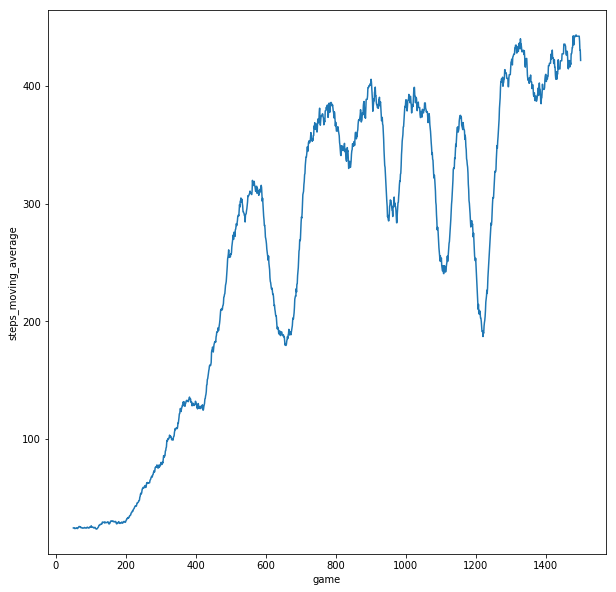

In [7]:
data['steps_moving_average'] = data['steps'].rolling(window=50).mean()
ax = data.plot('game','steps_moving_average', figsize=(10,10), legend=False)
ax.set_ylabel('steps_moving_average')

Text(0,0.5,'cost_moving_average')

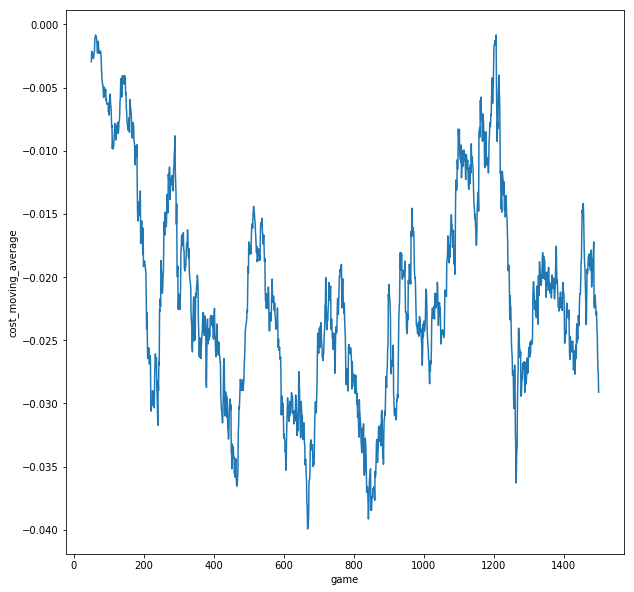

In [8]:
data['cost_moving_average'] = data['cost'].rolling(window=50).mean()
ax = data.plot('game','cost_moving_average', figsize=(10,10), legend=False)
ax.set_ylabel('cost_moving_average')

## Expolitation
Now that we have a trained agent, let see what it learned. We'll let it play the game, but this time we'll _expolit_ it's predictions - meaning we won't sample based on the predicted probabilities, but always take the action with the highest probability. Our goal is to reach the maximum number of possible steps.

The following cell will also render the graphic environment, so you can see how the agent playing.

In [9]:
env.reset()
env.render()
state = env.state
steps = 0
game_over = False
while not game_over:
    steps += 1
    probs = sess.run(action_prob, feed_dict={nn_states: np.expand_dims(state, axis=0)}).flatten()
    action = np.argmax(probs)
    state, _, game_over, _ = env.step(action)
    env.render()
end_reason = 'maximum possible steps' if steps == max_steps else 'dropped pole or left frame'
print("Game ended after {} steps ({})".format(steps, end_reason))

Game ended after 500 steps (maximum possible steps)


Terminate session once we're done:

In [10]:
sess.close()
env.close()